### Data to be used:Us_airline_sentiment_data_tweets.csv .

### Problem statement: use the respective columns from the above file and build a model for sentiment prediction. Guess the classes from data. Perform the necessary preprocessing. Do the train test split and at the end achieve the best train and test accuracy you can.

## import packages

In [35]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## import dataset 

In [36]:
air=pd.read_csv(r"C:\Users\Owner\Desktop\PGD DSML\Us_airline_sentiment_data_tweets.csv")

In [37]:
air.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,24-02-2015 11:35,NaN,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,24-02-2015 11:15,NaN,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,24-02-2015 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,24-02-2015 11:15,NaN,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,24-02-2015 11:14,NaN,Pacific Time (US & Canada)


## Exploratory Data Analysis

In [38]:
air.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791092e+14,0.162830,0.330440,0.745778
min,5.675880e+17,0.335000,0.000000,0.000000
25%,5.685590e+17,0.692300,0.360600,0.000000
50%,5.694780e+17,1.000000,0.670600,0.000000
75%,5.698902e+17,1.000000,1.000000,0.000000
max,5.703110e+17,1.000000,1.000000,44.000000


In [39]:
air.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

<AxesSubplot:ylabel='airline'>

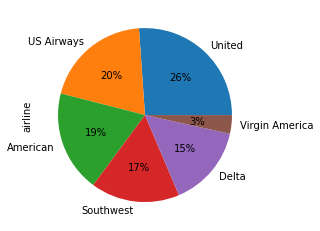

In [40]:
air.airline.value_counts().plot(kind='pie',autopct='%1.0f%%')

## The above piechart shows us distribution of tweets across all airlines. From this we can see most tweets are for united airlines and least for virgin america

In [41]:
air['airline_sentiment_gold'].value_counts()

negative    32
positive     5
neutral      3
Name: airline_sentiment_gold, dtype: int64

In [42]:
air['negativereason_gold'].value_counts()

Customer Service Issue                      12
Late Flight                                  4
Can't Tell                                   3
Cancelled Flight                             3
Cancelled Flight\nCustomer Service Issue     2
Late Flight\nFlight Attendant Complaints     1
Late Flight\nLost Luggage                    1
Bad Flight                                   1
Lost Luggage\nDamaged Luggage                1
Late Flight\nCancelled Flight                1
Flight Attendant Complaints                  1
Customer Service Issue\nLost Luggage         1
Customer Service Issue\nCan't Tell           1
Name: negativereason_gold, dtype: int64

<AxesSubplot:xlabel='negativereason', ylabel='count'>

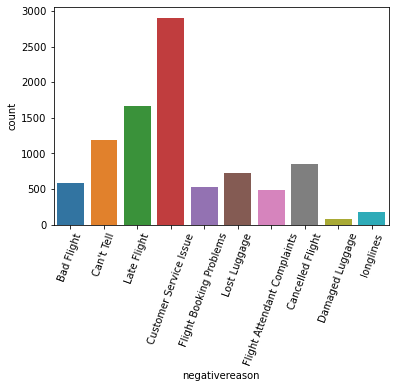

In [43]:
plt.xticks(rotation=70);
sns.countplot(x='negativereason',data=air)

## the above barchart shows that maximum negative tweets are for Service issue followed by Late flight and least are for aged luggage 

<AxesSubplot:xlabel='airline', ylabel='count'>

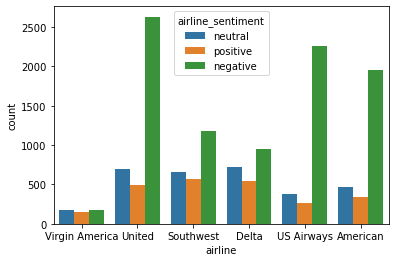

In [44]:
sns.countplot(x='airline',hue='airline_sentiment',data=air)

## This stacked barplot shows count of neutral,positive, negative sentiments for different airlines. 

<AxesSubplot:>

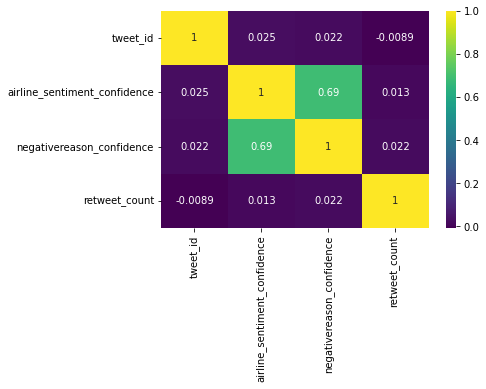

In [45]:
sns.heatmap(air.corr(),cmap='viridis',annot=True)

## The above heatmap shows correlation between various variables in data

<AxesSubplot:ylabel='airline_sentiment'>

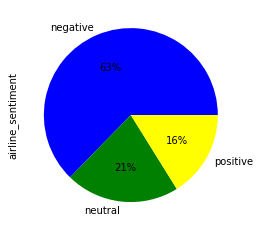

In [46]:
air.airline_sentiment.value_counts().plot(kind='pie',autopct="%1.0f%%",colors=['blue','green','yellow'])

##  The above pie chart shows percentage of distribution of sentiments in whole data. Here we can see 63% of sentiments are negative, 21% are neutral and 16% are positive.

## Data cleaning

In [47]:
features = air.iloc[:, 10].values
labels = air.iloc[:, 1].values

In [48]:
features

array(['@VirginAmerica What @dhepburn said.',
       "@VirginAmerica plus you've added commercials to the experience... tacky.",
       "@VirginAmerica I didn't today... Must mean I need to take another trip!",
       ...,
       '@AmericanAir Please bring American Airlines to #BlackBerry10',
       "@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",
       '@AmericanAir we have 8 ppl so we need 2 know how many seats are on the next flight. Plz put us on standby for 4 people on the next flight?'],
      dtype=object)

In [49]:
labels

array(['neutral', 'positive', 'neutral', ..., 'neutral', 'negative',
       'neutral'], dtype=object)

In [50]:
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

In [53]:
corpus = list(processed_features)
vectorizer = CountVectorizer()
vectorizer.fit(corpus)
X = vectorizer.transform(corpus)
y = labels

## Splitting data into train and test set

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [55]:
X_train.shape

(9808, 15051)

## logistic model

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score



clf = LogisticRegression()
clf.fit(X_train, y_train)
train_prediction = clf.predict(X_train.toarray())
print(f"The training accuracy is {accuracy_score(y_train, train_prediction)}")

C:\Users\Owner\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The training accuracy is 0.9593189233278956


## We got 95% training accuracy for logistic regression classification model

In [57]:
test_prediction = clf.predict(X_test.toarray())
print(f"The testing accuracy is {accuracy_score(y_test, test_prediction)}")

The testing accuracy is 0.7942880794701986


## We got 79% testing accuracy for logistic regression classification

In [58]:
clf

LogisticRegression()

## Random forest classifier

In [61]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [62]:
predictions = text_classifier.predict(X_test)

In [63]:
from sklearn.metrics import confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print('accuracy score',accuracy_score(y_test, predictions))

[[2975   89   21]
 [ 535  407   42]
 [ 333   83  347]]
accuracy score 0.7717301324503312


## We got 77% accuracy for random forest classification model